In [ ]:
#   This software component is licensed by ST under BSD-3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#             https://opensource.org/licenses/BSD-3-Clause

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/HAR/Human_Activity_Recognition.ipynb)

# Human Activity Recognition

This notebook shows the process of creating a basic motion sensing activity classifier model, using Keras, for STM32 embedded applications.


## Import TensorFlow

Use TensorFlow 2.5.0 to be aligned with X-CUBE-AI v7.0.0.

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.19.0


## Loading the dataset

The dataset is composed of 3-axis acceleration values stored in `.csv` text format. Each individual file corresponds to a capture characterised by it's containing folder name.

Download and extract the dataset:

In [2]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip

--2026-01-20 09:42:04--  https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/STMicroelectronics/stm32ai-wiki/raw/master/AI_resources/HAR/dataset.zip [following]
--2026-01-20 09:42:04--  https://github.com/STMicroelectronics/stm32ai-wiki/raw/master/AI_resources/HAR/dataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/STMicroelectronics/stm32ai-wiki/master/AI_resources/HAR/dataset.zip [following]
--2026-01-20 09:42:04--  https://raw.githubusercontent.com/STMicroelectronics/stm32ai-wiki/master/AI_resources/HAR/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecti

In [3]:
!unzip -n dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/LICENSE         
  inflating: dataset/README.md       
   creating: dataset/running/
  inflating: dataset/running/running_01_26Hz_4g_mg.csv  
  inflating: dataset/running/running_02_26Hz_4g_mg.csv  
  inflating: dataset/running/running_03_26Hz_4g_mg.csv  
  inflating: dataset/running/running_04_26Hz_4g_mg.csv  
  inflating: dataset/running/running_05_26Hz_4g_mg.csv  
  inflating: dataset/running/running_06_26Hz_4g_mg.csv  
  inflating: dataset/running/running_07_26Hz_4g_mg.csv  
  inflating: dataset/running/running_08_26Hz_4g_mg.csv  
  inflating: dataset/running/running_09_26Hz_4g_mg.csv  
  inflating: dataset/running/running_10_26Hz_4g_mg.csv  
  inflating: dataset/running/running_12_26Hz_4g_mg.csv  
  inflating: dataset/running/running_13_26Hz_4g_mg.csv  
  inflating: dataset/running/running_14_26Hz_4g_mg.csv  
  inflating: dataset/running/running_15_26Hz_4g_mg.csv  
  inflating: dataset/running/running_16_26Hz_4g_mg.c

Load the dataset into memory:

In [4]:
import glob
import numpy as np

# Load data into memory
labels = ['stationary', 'walking', 'running']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)

x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 3)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)

(92, 1000, 3)
(92,)


## Exploring the dataset
To verify that the dataset has been loaded correctly, let's display and plot a few captures at random.

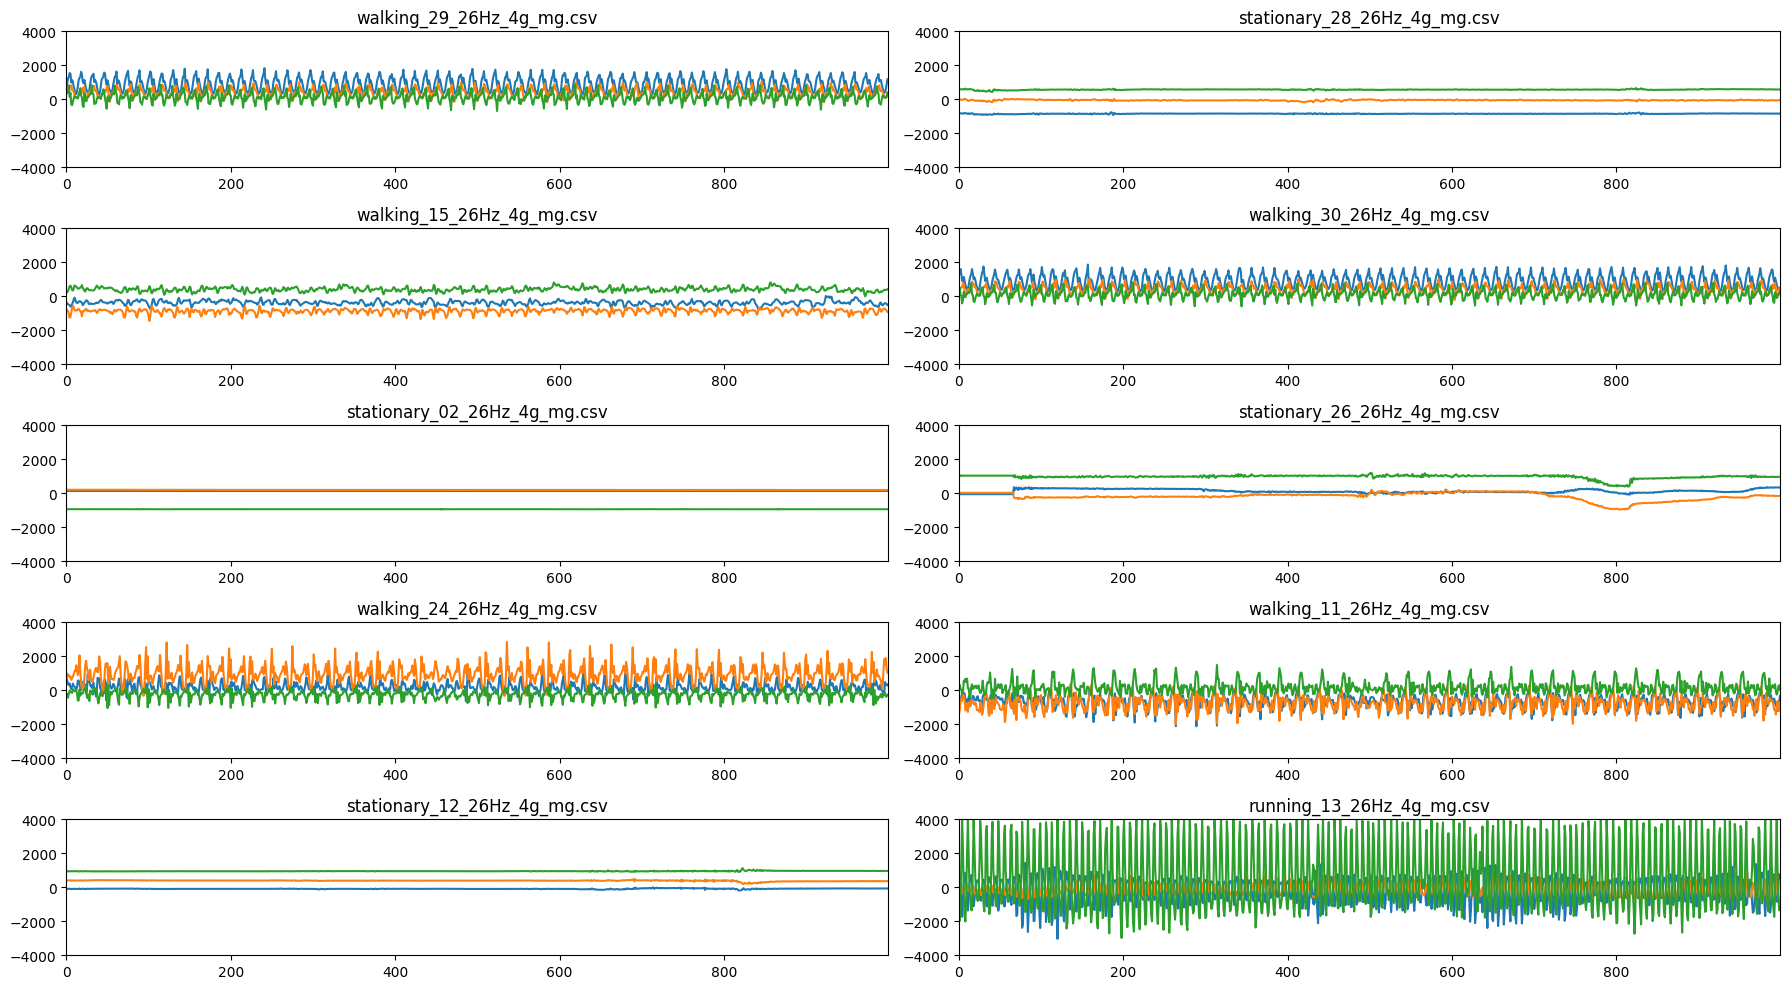

In [5]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

## Frame data

Each capture is framed into smaller windows. The window size will be the input dimension for the neural network. Optional overlapping can be added to further increase the number of points in our data for training and testing.

Here we are dividing the dataset into 1 second frames (26 samples at 26 Hz):

In [6]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 3))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 26, 13) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(92, 75, 26, 3)
(6900, 26, 3)
(6900,)
['stationary', 'walking', 'running']


## Preprocessing the dataset

To improve the model's performance, it is recommended to perform some kind of pre-processing on the input data before feeding them to the neural network model. Data pre-processing can include filtering, gravity rotation and/or suppression as it is done in [FP-AI-SENSING1]. In this example, a simple data scaling will suffice.

Data scaling can be achieved by normalizing or standardizing input data. In this example, data is normalized into floating point values between `-1.0` and `1.0` by dividing them by the sensor's full range (`4000 mg`).

[FP-AI-SENSING1]:https://www.st.com/en/embedded-software/fp-ai-sensing1.html

In [7]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

### Preparing the dataset (train, test, split)
The dataset is split into a _train_ and _test_ set. The data is first shuffled and then split with 25% reserved for model evaluation and testing purposes.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_frames_normed, y_frames, test_size=0.25)

print("Trainning samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Trainning samples: (5175, 26, 3)
Testing samples: (1725, 26, 3)


## Creating the model

Let's create a classifier model using Keras.

Build the tf.keras.Sequential model by stacking layers. Choose an optimizer and loss function for training:

In [9]:
## Conv1D based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(26, 3)),
  tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print("Test loss:", test_loss)
print("Test acc:", test_acc)
model.summary()

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5682 - loss: 0.9093
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9018 - loss: 0.2873
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9614 - loss: 0.1365
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9582 - loss: 0.1221
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9680 - loss: 0.1029
Epoch 6/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9730 - loss: 0.0911
Epoch 7/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9711 - loss: 0.0932
Epoch 8/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9721 - loss: 0.0792
Epoch 9/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.0803
Epoch 10/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9702 - loss: 0.0877
Epoch 11/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9736 - loss: 0.0767
Epoch 12/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 16)         │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 176)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        11,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,227 (141.52 KB)

 Trainable params: 12,075 (47.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,152 (94.35 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


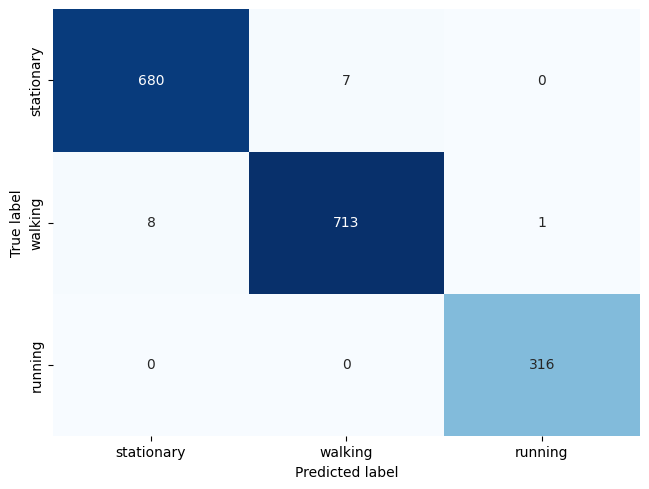

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
# Save the model into an Keras file ‘model.keras’
model.save('model.keras')

In [14]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_name = 'HAR_Classification'  # Will be given .tflite suffix
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

Saved artifact at '/tmp/tmp1iziiscu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 26, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137955433095312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137955433096272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137955433094928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137955433095888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137955433097808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137955433098768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137955433097040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137955433099152: TensorSpec(shape=(), dtype=tf.resource, name=None)


19032